# interactive notebooks

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

pyAgrum can easily interact with other applications. In this notebook, we propose for example some application tracks with notebook ipywidgets to make the exploration of graphical models and their inferences more interactive.

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Listeners and progress bars

In [2]:
import glob
import os.path
from tqdm.auto import tqdm

class TqdmProgressBarLoadListener:
    def __init__(self,filename:str):
        self.pbar=tqdm(total=100,
                      desc=filename,
                      bar_format='{desc}: {percentage:3.0f}%|{bar}|')
    def update(self,progress):
        if progress==200:
            self.pbar.close()
        else:
            self.pbar.update()
            self.pbar.display()
        

bns={}
for ext in ['dsl','bif']:
    for name in glob.glob(f"res/*.{ext}"):
        progbar=TqdmProgressBarLoadListener(name)
        bns[os.path.basename(name)]=gum.loadBN(name,listeners=[lambda progress:progbar.update(progress)])

res\alarm.dsl:   0%|          |

res\asia.bif:   0%|          |

res\asthma.bif:   0%|          |

res\Diabetes.bif:   0%|          |

Which should give you something like 

![a progess bar](images/progressBar.gif)

## Animated graphs

ipywidget can be used with different types of objects. Let's say that you have a class that show the arcs of a Bayesian network only the mutual information of this arc is above a certain threshold:

In [3]:
import pydot as dot

class InformationViewer:
    def __init__(self,bn:gum.BayesNet):
        self.bn=bn

        ie=gum.LazyPropagation(bn)
        self._min=float("inf")
        self._max=float("-inf")
        self._arcs={}        
        for x,y in bn.arcs():
            nameX=bn.variable(x).name()
            nameY=bn.variable(y).name()
            ie.addJointTarget({nameX,nameY})
            info=gum.InformationTheory(ie,[nameX],[nameY])
            m=info.mutualInformationXY()
            if self._min>m: self._min=m
            if self._max<m: self._max=m
            self._arcs[x,y]=m

    def min(self):
        return self._min

    def max(self):
        return self._max

    def showBN(self,minVal:float=0):
        graph=dot.Dot(graph_type="digraph",bgcolor="transparent")
        bgcol = gum.config["notebook", "default_node_bgcolor"]
        fgcol = gum.config["notebook", "default_node_fgcolor"]
        for n in self.bn.names():
            graph.add_node(dot.Node('"' + n + '"', style="filled",
                                    fillcolor=bgcol,
                                    fontcolor=fgcol))
        for x,y in self.bn.arcs():
            graph.add_edge(dot.Edge('"' + self.bn.variable(x).name() + '"', 
                                    '"' + self.bn.variable(y).name() + '"',
                                    style="invis" if self._arcs[x,y]<minVal else ""))


        size = gum.config["notebook", "default_graph_size"]
        graph.set_size(size)
        return graph
    
view=InformationViewer(bns['alarm.dsl'])
print(f"min={view.min()} ,max={view.max()}")
gnb.sideBySide(view.showBN(0.3),view.showBN(0.5),
              captions=["BN filtered by $MI>0.3$","BN filtered by $MI>0.5$"])

min=7.940532588369736e-06 ,max=0.8850119269966232


Now we can use this class for animation :

In [4]:
import ipywidgets as widgets
def interactive_view(threshold:float):
    return view.showBN(threshold)
widgets.interact(interactive_view,threshold=(view.min(),
                                             view.max(),
                                             (view.max()-view.min())/100.0));

interactive(children=(FloatSlider(value=0.4425099337646058, description='threshold', max=0.8850119269966232, m…

Which should give you something like 

![a progess bar](images/mutInfThreshold.gif)

## Vizualizing evidence impact




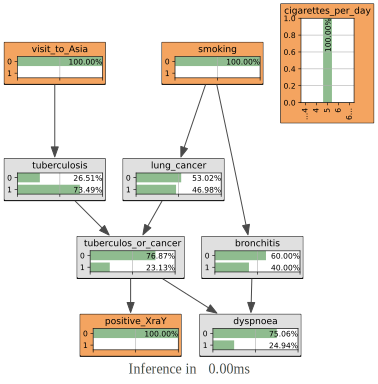

interactive(children=(Dropdown(description='visit_to_Asia', options=('0', '1'), value='0'), Dropdown(descripti…

In [5]:
from ipywidgets import interact, fixed

bn = bns['asia.bif']

asia = list(bn["visit_to_Asia"].labels())
smoking = list(bn["smoking"].labels())
XraY = list(bn["positive_XraY"].labels())
cig_ped_day = gum.RangeVariable("cigarettes_per_day","cigarettes_per_day in [0, 10]?",0,10)
bn.add(cig_ped_day)

@interact(bn=fixed(bn), visit_to_Asia=asia, smoking=smoking, positive_XraY=XraY, smoked_cigarettes=(cig_ped_day.minVal(), cig_ped_day.maxVal(), 1))
def evidence_impact(bn, visit_to_Asia, smoking, positive_XraY, smoked_cigarettes):
    evs = {"visit_to_Asia":visit_to_Asia, "smoking":smoking, "positive_XraY":positive_XraY, "cigarettes_per_day":smoked_cigarettes}
    gnb.showInference(bn, evs=evs)